In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import kstest, lognorm, norm
import numpy as np

# Load the CSV file into a DataFrame
df = pd.read_csv('data/blockchain_difficulty.csv') # columns = ['Date', 'difficulty', 'market-price']

# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'], format="ISO8601")

# Set the 'Date' column as the index for better plotting control
df.set_index('Date', inplace=True)

df['price-ratio'] = df['market-price'].replace(0, np.nan) / df['difficulty'].replace(0, np.nan)

# Avoid log of zero: replace 0 with NaN for calculation, which will be ignored
df['log-difficulty'] = np.log(df['difficulty'].replace(0, np.nan))
df['log-price'] = np.log(df['market-price'].replace(0, np.nan))

# Add column log-price-ratio from log-price / log-difficulty, excluding NaNs and zero values
df['log-price-ratio'] = np.log(df['market-price'].replace(0, np.nan) / df['difficulty'].replace(0, np.nan))

# Add column 'log-return' as natural log of market-price to its value on the prior day using shift
df['log-return'] = np.log(df['market-price'] / df['market-price'].shift(1))

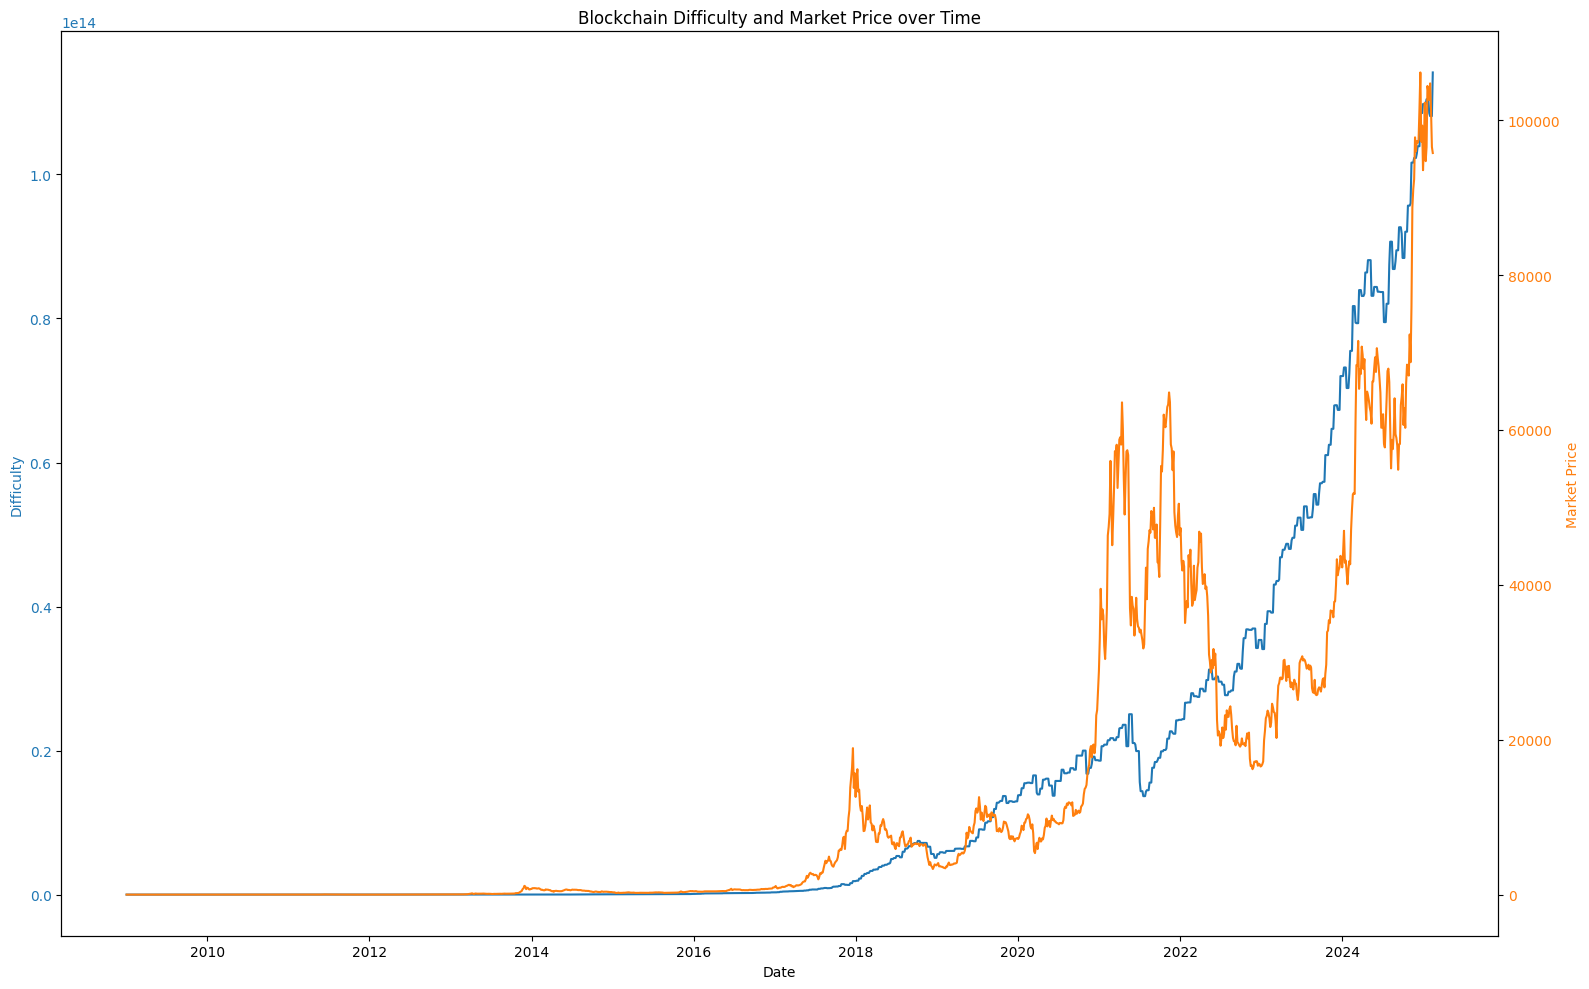

In [2]:
# Create a figure and a set of subplots with two y-axes
fig, ax1 = plt.subplots(figsize=(16, 10))  # Adjust plot size to 16x10

# Plot 'difficulty' on the first y-axis
ax1.set_xlabel('Date')
ax1.set_ylabel('Difficulty', color='tab:blue')
ax1.plot(df.index, df['difficulty'], color='tab:blue', label='Difficulty')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Market Price', color='tab:orange')
ax2.plot(df.index, df['market-price'], color='tab:orange', label='Market Price')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Add a title and display the plot
plt.title("Blockchain Difficulty and Market Price over Time")
fig.tight_layout()  # Adjust layout to prevent overlap
plt.show()

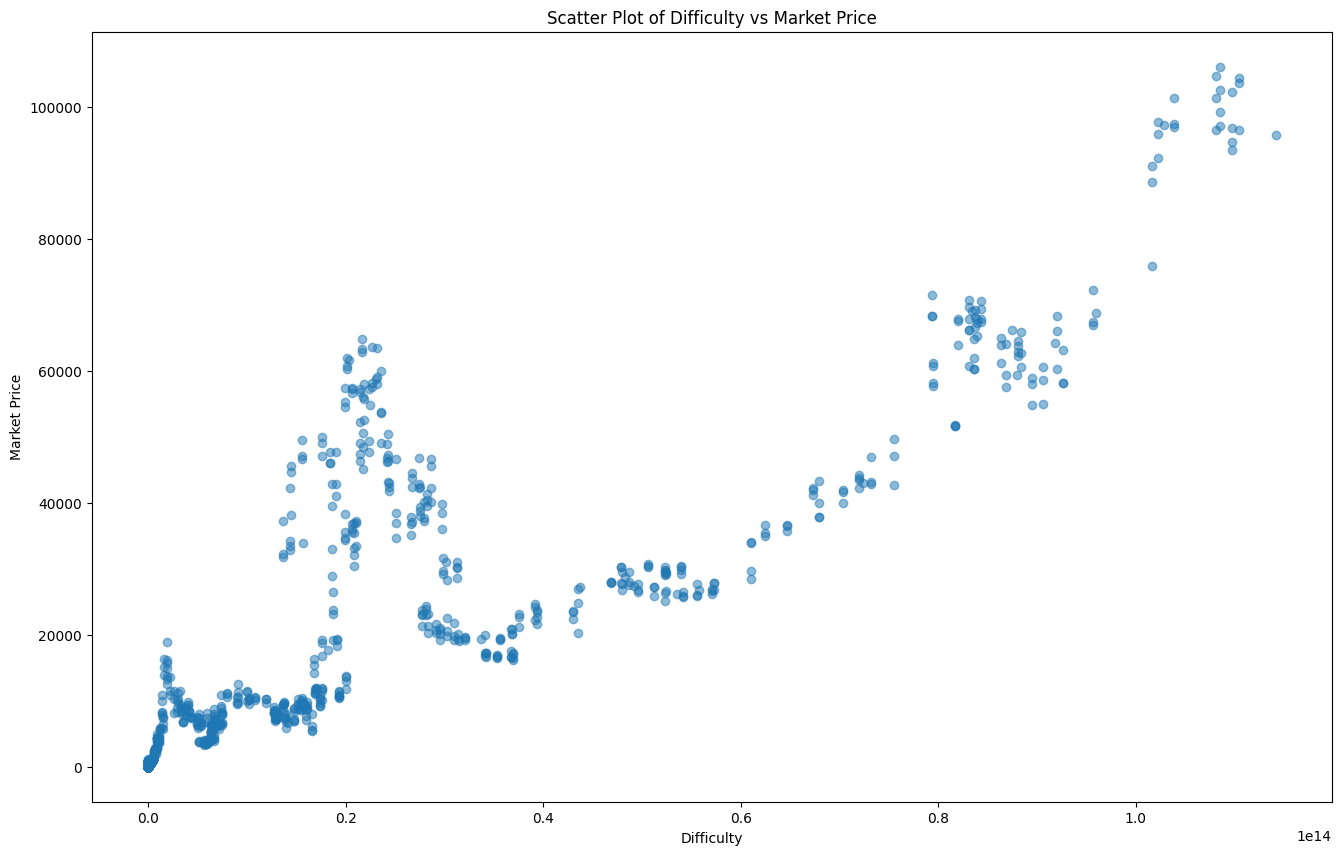

In [3]:
# Create a scatter plot for difficulty vs market-price
plt.figure(figsize=(16, 10))  # Adjust plot size to 16x10
plt.scatter(df['difficulty'], df['market-price'], alpha=0.5)

# Add labels and title
plt.xlabel('Difficulty')
plt.ylabel('Market Price')
plt.title("Scatter Plot of Difficulty vs Market Price")

# Display the plot
plt.show()

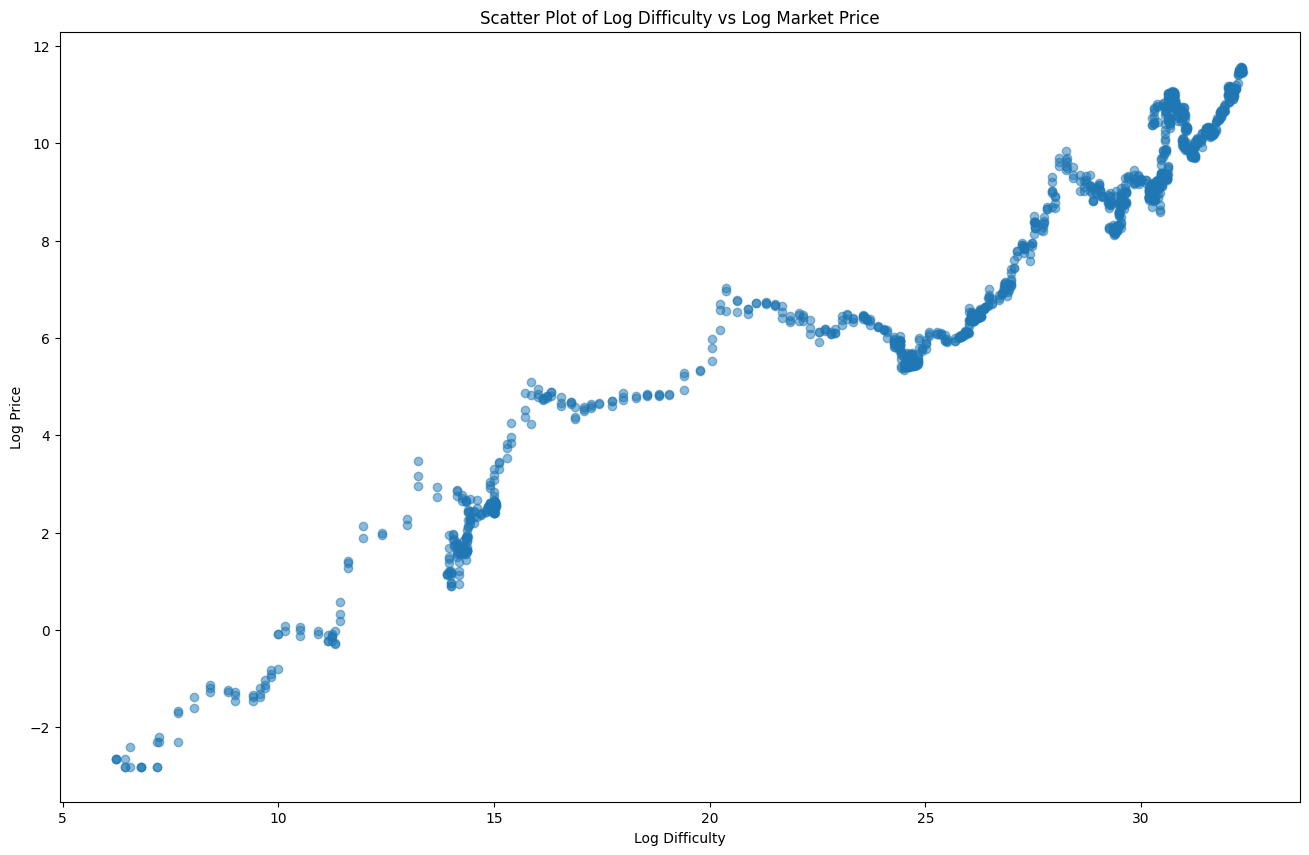

In [4]:
# Create a scatter plot for difficulty vs market-price
plt.figure(figsize=(16, 10))  # Adjust plot size to 16x10
plt.scatter(df['log-difficulty'], df['log-price'], alpha=0.5)

# Add labels and title
plt.xlabel('Log Difficulty')
plt.ylabel('Log Price')
plt.title("Scatter Plot of Log Difficulty vs Log Market Price")

# Display the plot
plt.show()

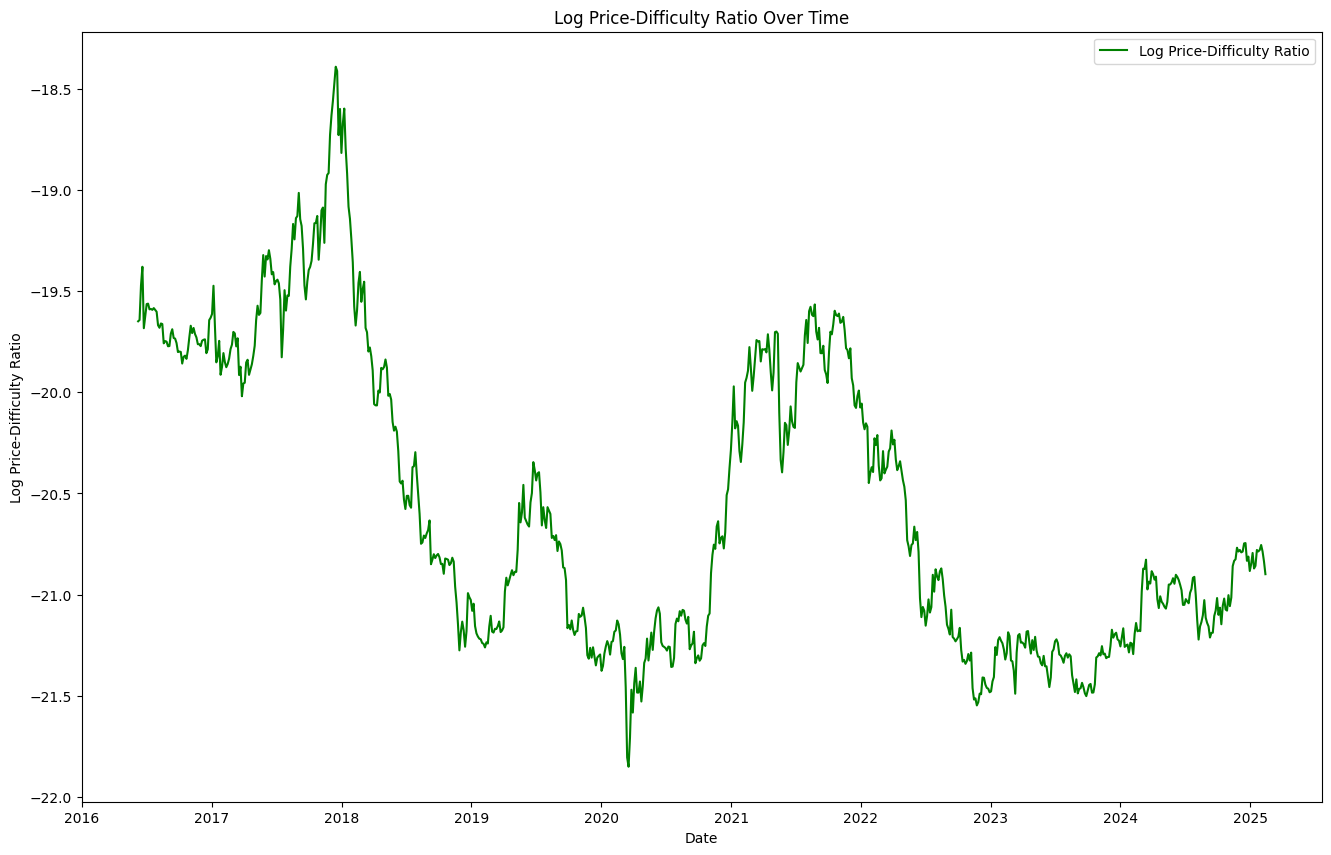

In [5]:
# Create a new filtered DataFrame for dates greater than 1 January 2016
df_filtered = df[(df.index > '2016-06-04')] #(df.index < '2018-06-04')

# Create a figure and plot 'log-price-ratio' over time
plt.figure(figsize=(16, 10))  # Adjust plot size to 16x10

# Plot 'log-price-ratio' over time
plt.plot(df_filtered.index, df_filtered['log-price-ratio'], label='Log Price-Difficulty Ratio', color='green')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Log Price-Difficulty Ratio')
plt.title('Log Price-Difficulty Ratio Over Time')

# Add legend
plt.legend()

# Display the plot
plt.show()


Kolmogorov-Smirnov test for log-price-ratio being log-normal:
Statistic: 0.1365797991951178, p-value: 2.2186605373331693e-13

Kolmogorov-Smirnov test: log-price does not appear to follow a lognormal distribution.


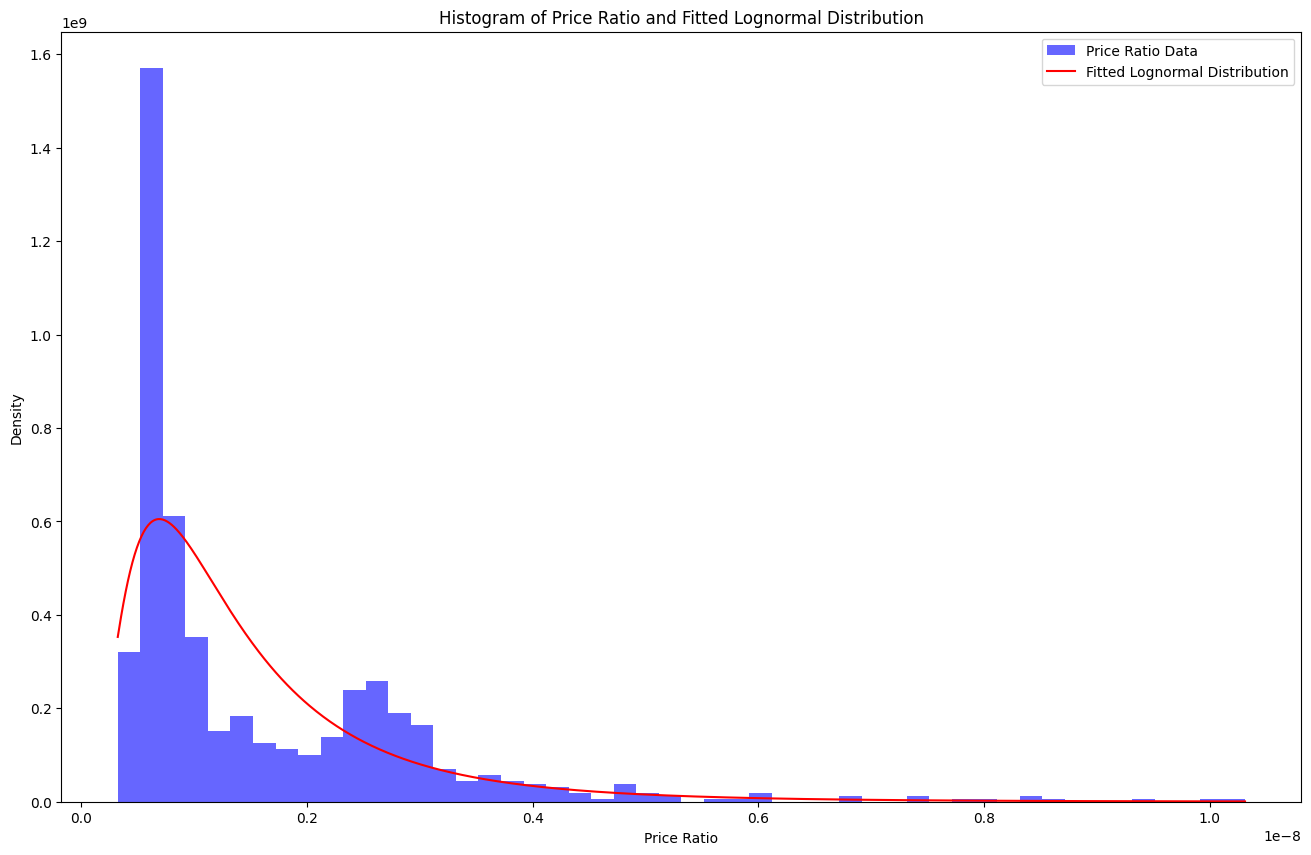

In [6]:
# Exclude NaN values for the tests
price_ratio = df_filtered['price-ratio'].dropna()

# Lognormal test (Kolmogorov-Smirnov Goodness of Fit)
shape, loc, scale = lognorm.fit(price_ratio, floc=0)  # Fit log-normal parameters
lognormal_cdf = lambda x: lognorm.cdf(x, shape, loc=loc, scale=scale)
stat3, p = kstest(price_ratio, lognormal_cdf)
print("\nKolmogorov-Smirnov test for log-price-ratio being log-normal:")
print(f"Statistic: {stat3}, p-value: {p}")

# Interpret the results for all tests
alpha = 0.05
if p > alpha:
    print("\nKolmogorov-Smirnov test: log-price appears to follow a lognormal distribution.")
else:
    print("\nKolmogorov-Smirnov test: log-price does not appear to follow a lognormal distribution.")

# Plot a histogram of the price_ratio and the fitted lognormal distribution
plt.figure(figsize=(16, 10))  # Adjust size of the plot

# Plot histogram of the data
count, bins, _ = plt.hist(price_ratio, bins=50, density=True, alpha=0.6, color='blue', label="Price Ratio Data")

# Overlay the fitted lognormal distribution
x = np.linspace(min(price_ratio), max(price_ratio), 1000)
pdf = lognorm.pdf(x, shape, loc=loc, scale=scale)  # Fitted PDF
plt.plot(x, pdf, 'r-', label='Fitted Lognormal Distribution')

# Add title and labels
plt.title('Histogram of Price Ratio and Fitted Lognormal Distribution')
plt.xlabel('Price Ratio')
plt.ylabel('Density')

# Add legend
plt.legend()

# Display the plot
plt.show()

C:\dev\crypto-series\btc-model\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:6902: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


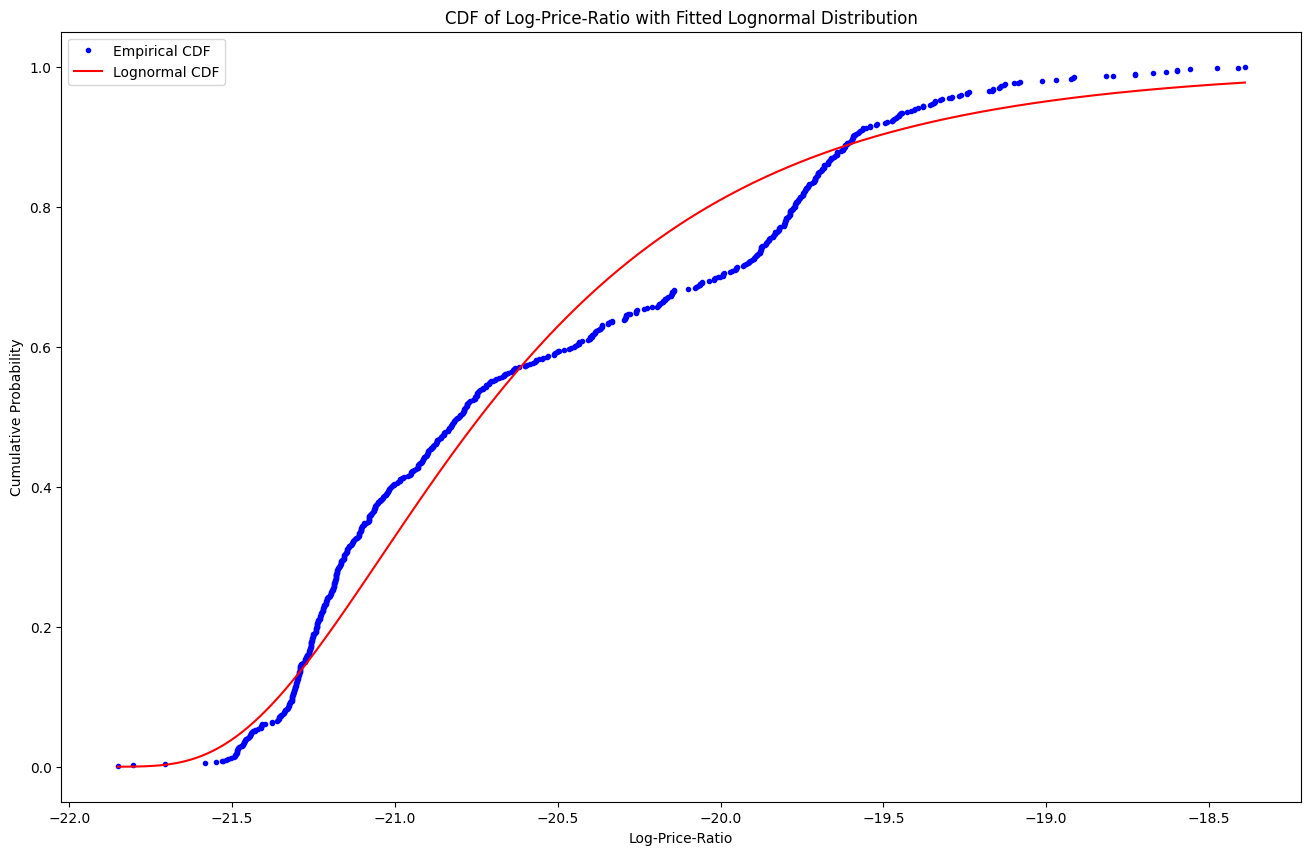

In [7]:
# Exclude NaN values and filter the log-price-ratio
log_price_ratio = df_filtered['log-price-ratio'].dropna()

# Create a figure for the CDF plot
plt.figure(figsize=(16, 10))

# Plot the empirical CDF of 'log-price-ratio'
sorted_values = np.sort(log_price_ratio)
y_vals = np.arange(1, len(sorted_values) + 1) / len(sorted_values)
plt.plot(sorted_values, y_vals, marker='.', linestyle='none', label='Empirical CDF', color='blue')

# Fit a lognormal distribution to 'log-price-ratio'
shape, loc, scale = lognorm.fit(log_price_ratio)
x_vals = np.linspace(sorted_values.min(), sorted_values.max(), 1000)
cdf_vals = lognorm.cdf(x_vals, shape, loc=loc, scale=scale)

# Plot the fitted lognormal CDF
plt.plot(x_vals, cdf_vals, label='Lognormal CDF', color='red')

# Add labels, title, and legend
plt.xlabel('Log-Price-Ratio')
plt.ylabel('Cumulative Probability')
plt.title('CDF of Log-Price-Ratio with Fitted Lognormal Distribution')
plt.legend()

# Display the plot
plt.show()

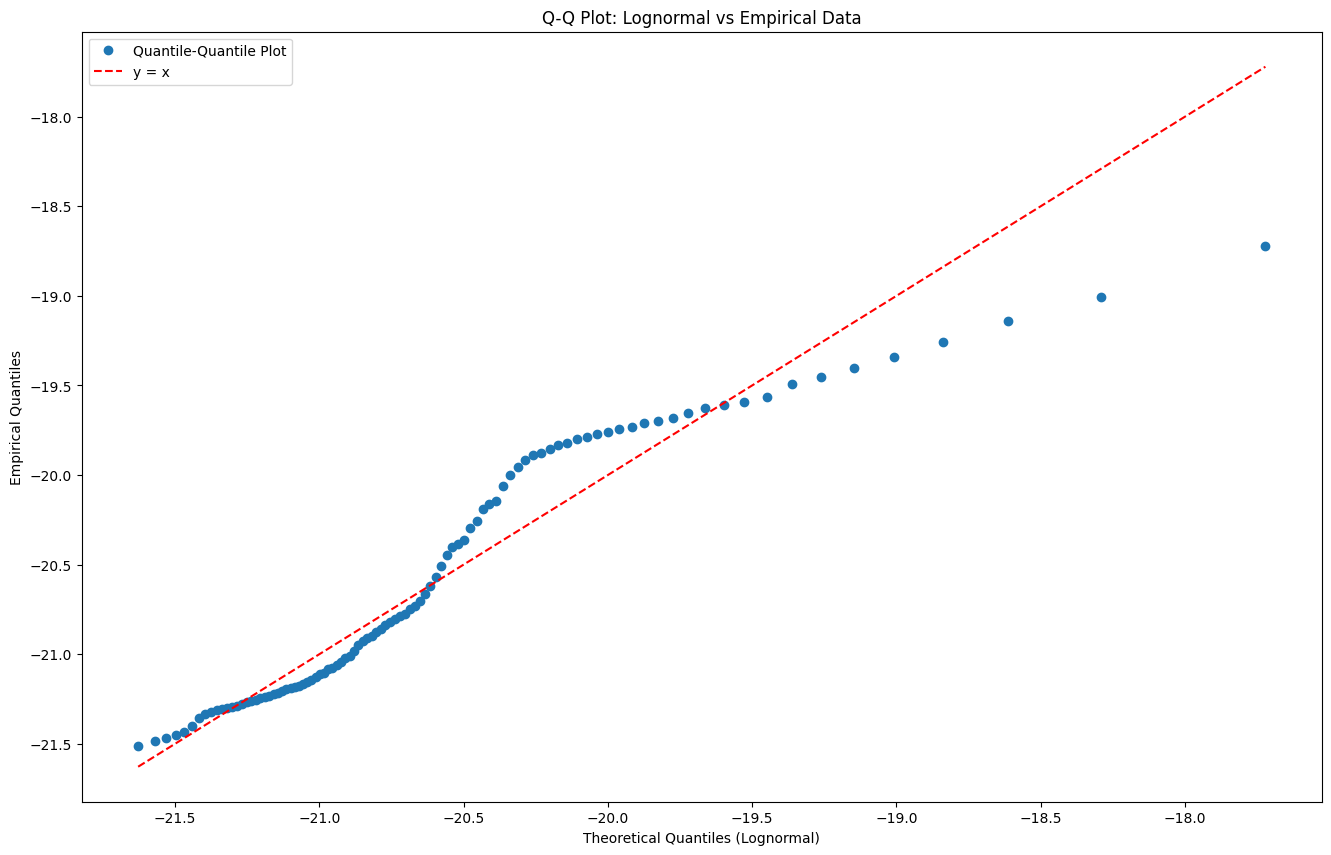

In [8]:
# Calculate the quantiles for the lognormal distribution and empirical data
quantiles_lognorm = lognorm.ppf(np.arange(0.01, 1, 0.01), s=shape, loc=loc, scale=scale)  # Avoid zero in range
quantiles_y_vals = np.quantile(sorted_values, np.arange(0.01, 1, 0.01))  # Match range with quantiles_lognorm

# Create a figure for the quantile-quantile plot
plt.figure(figsize=(16, 10))
plt.plot(quantiles_lognorm, quantiles_y_vals, marker='o', linestyle='', label='Quantile-Quantile Plot')

# Plot y = x on the chart for reference
plt.plot(quantiles_lognorm, quantiles_lognorm, color='red', linestyle='--', label='y = x')

# Add labels, title, and legend
plt.xlabel('Theoretical Quantiles (Lognormal)')
plt.ylabel('Empirical Quantiles')
plt.title('Q-Q Plot: Lognormal vs Empirical Data')
plt.legend()

# Display the plot
plt.show()

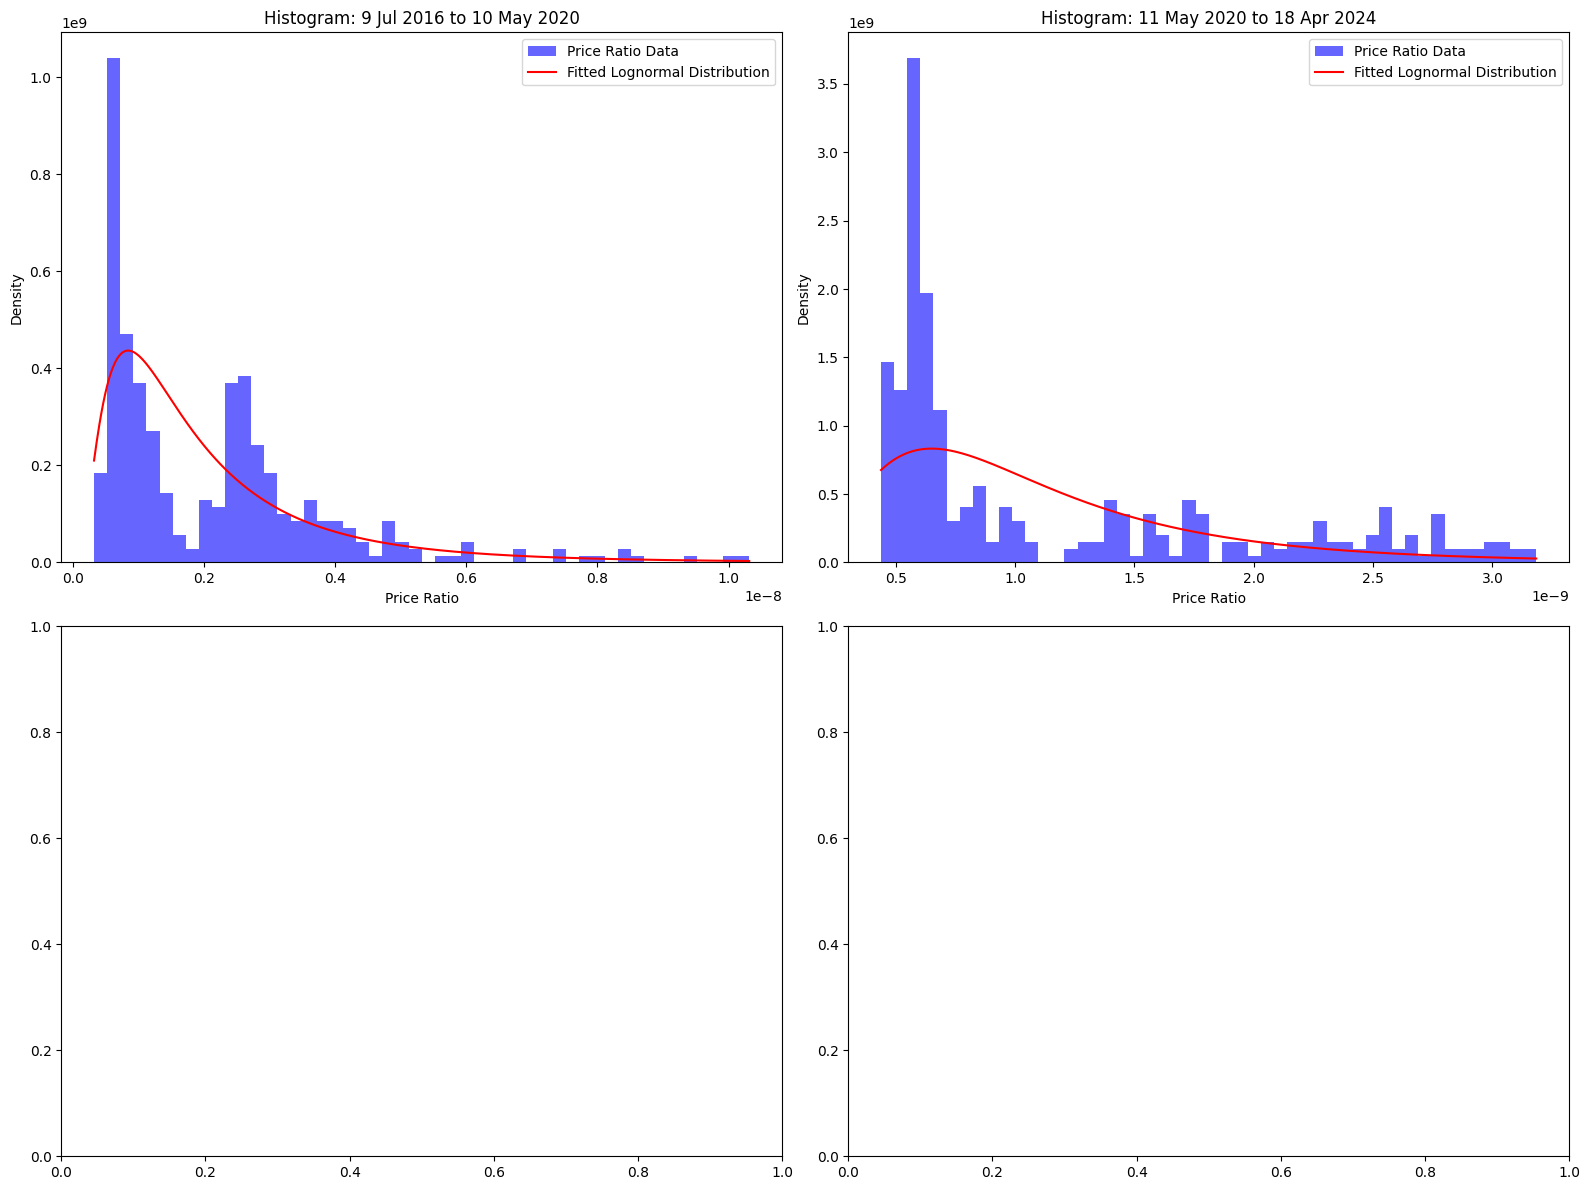

In [9]:
# Define the date ranges
date_ranges = {
    #'Start to 27 Nov 2012': ('1900-01-01', '2012-11-27'),
    #'28 Nov 2012 to 8 Jul 2016': ('2012-11-28', '2016-07-08'),
    '9 Jul 2016 to 10 May 2020': ('2016-07-09', '2020-05-10'),
    '11 May 2020 to 18 Apr 2024': ('2020-05-11', '2024-04-18')
}

# Slice the data into four datasets
sliced_data = {label: df_filtered[(df_filtered.index >= start) & (df_filtered.index <= end)]['price-ratio'].dropna()
               for label, (start, end) in date_ranges.items()}

# Create subplots for histograms
fig, axes = plt.subplots(2, 2, figsize=(16, 12))  # 2x2 grid of subplots
axes = axes.flatten()  # Flatten for easy indexing

for ax, (label, data) in zip(axes, sliced_data.items()):
    if data is None or len(data) == 0:
        print(f"Warning: Data subset '{label}' is empty. Skipping...")
        continue

    # Lognormal fit for each subset
    shape, loc, scale = lognorm.fit(data, floc=0)
    x = np.linspace(min(data), max(data), 1000)
    pdf = lognorm.pdf(x, shape, loc=loc, scale=scale)

    # Plot the histogram and fitted PDF
    count, bins, _ = ax.hist(data, bins=50, density=True, alpha=0.6, color='blue', label="Price Ratio Data")
    ax.plot(x, pdf, 'r-', label='Fitted Lognormal Distribution')

    # Add titles, labels, and legend
    ax.set_title(f'Histogram: {label}')
    ax.set_xlabel('Price Ratio')
    ax.set_ylabel('Density')
    ax.legend()

# Adjust layout and show the grid
plt.tight_layout()
plt.show()

Wilcoxon Rank Sum Test Results for distribution means:
Test Statistic: 9.398017244804159
p-value: 5.560091551536531e-21
Reject null hypothesis: There is a significant difference between the distributions.

Kolmogorov-Smirnov test for distribution comparison:
Statistic: 0.3056267806267806, 
p-value: 3.519606299753374e-15
Reject null hypothesis: There is a significant difference between the distributions.


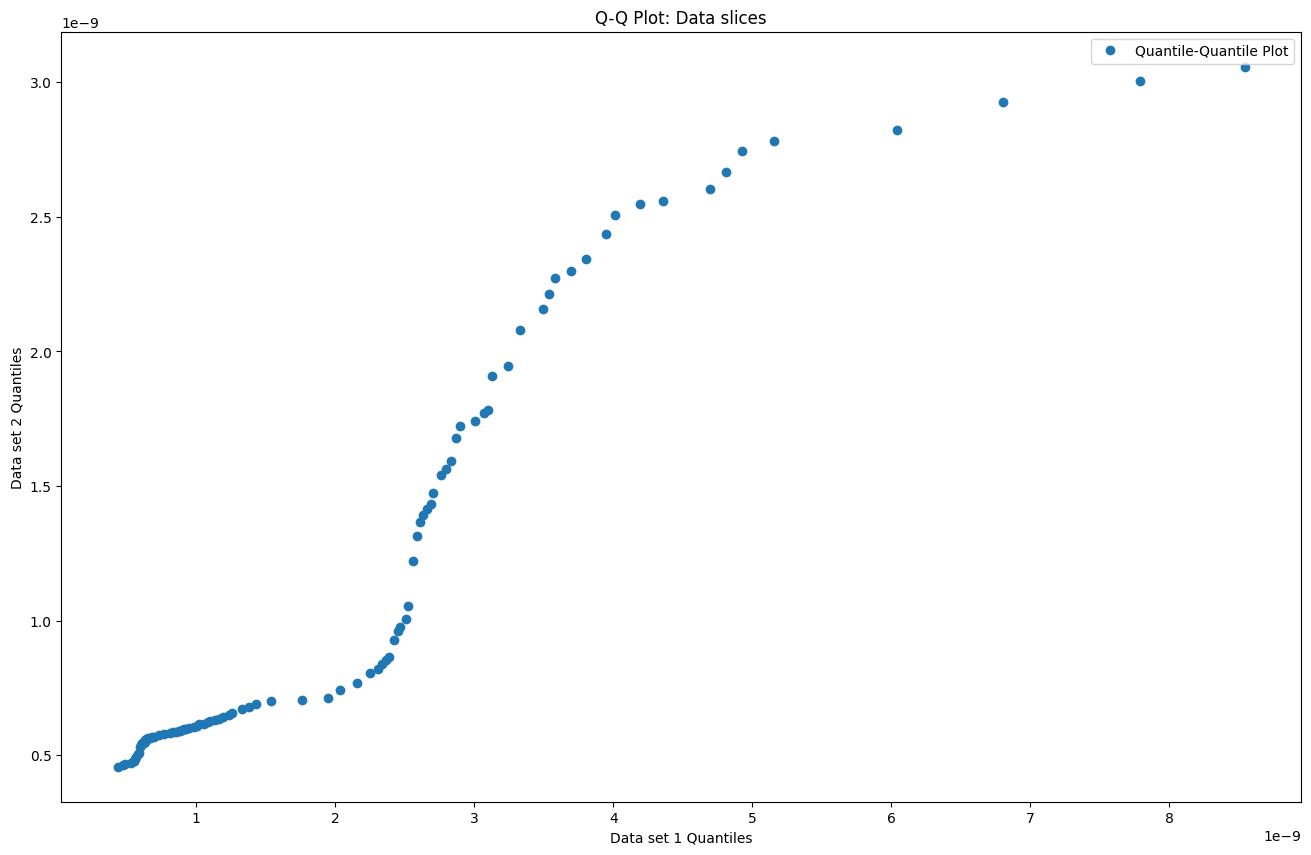

In [10]:
# Sample data (replace with your actual data)
data1 = np.sort(sliced_data.get('9 Jul 2016 to 10 May 2020'))
data2 = np.sort(sliced_data.get('11 May 2020 to 18 Apr 2024'))

# Perform Wilcoxon Rank Sum Test
statistic, pvalue = stats.ranksums(data1, data2)

# Print test results
print("Wilcoxon Rank Sum Test Results for distribution means:")
print("Test Statistic:", statistic)
print("p-value:", pvalue)

# Decide on rejecting the null hypothesis based on significance level (e.g., 0.05)
if pvalue < 0.05:
    print("Reject null hypothesis: There is a significant difference between the distributions.")
else:
    print("Fail to reject null hypothesis: Insufficient evidence to conclude a difference.")

print()

# Perform Kruskal-Wallis test
stat, p = kstest(data1, data2)

print("Kolmogorov-Smirnov test for distribution comparison:")
print(f"Statistic: {stat}, \np-value: {p}")
if pvalue < 0.05:
    print("Reject null hypothesis: There is a significant difference between the distributions.")
else:
    print("Fail to reject null hypothesis: Insufficient evidence to conclude a difference.")

# Calculate the quantiles for the lognormal distribution and empirical data
quantiles_x_vals = np.quantile(data1, np.arange(0.01, 1, 0.01))
quantiles_y_vals = np.quantile(data2, np.arange(0.01, 1, 0.01))

# Create a figure for the quantile-quantile plot
plt.figure(figsize=(16, 10))
plt.plot(quantiles_x_vals, quantiles_y_vals, marker='o', linestyle='', label='Quantile-Quantile Plot')

# Add labels, title, and legend
plt.xlabel('Data set 1 Quantiles')
plt.ylabel('Data set 2 Quantiles')
plt.title('Q-Q Plot: Data slices')
plt.legend()

# Display the plot
plt.show()


Kolmogorov-Smirnov test for distribution comparison (2016-06-07 to 2017-06-07 to 2017-06-07 to 2018-06-07):
Statistic: 0.18788819875776397, 
p-value: 0.07008086486178827
Fail to reject null hypothesis: Insufficient evidence to conclude a difference.

Kolmogorov-Smirnov test for distribution comparison (2017-06-07 to 2018-06-07 to 2018-06-07 to 2019-06-07):
Statistic: 0.21978021978021978, 
p-value: 0.024382591167278086
Reject null hypothesis: There is a significant difference between the distributions.

Kolmogorov-Smirnov test for distribution comparison (2018-06-07 to 2019-06-07 to 2019-06-07 to 2020-06-06):
Statistic: 0.14285714285714285, 
p-value: 0.31234052478072455
Fail to reject null hypothesis: Insufficient evidence to conclude a difference.

Kolmogorov-Smirnov test for distribution comparison (2019-06-07 to 2020-06-06 to 2020-06-06 to 2021-06-06):
Statistic: 0.16794075489727664, 
p-value: 0.13464108648120052
Fail to reject null hypothesis: Insufficient evidence to conclude a dif

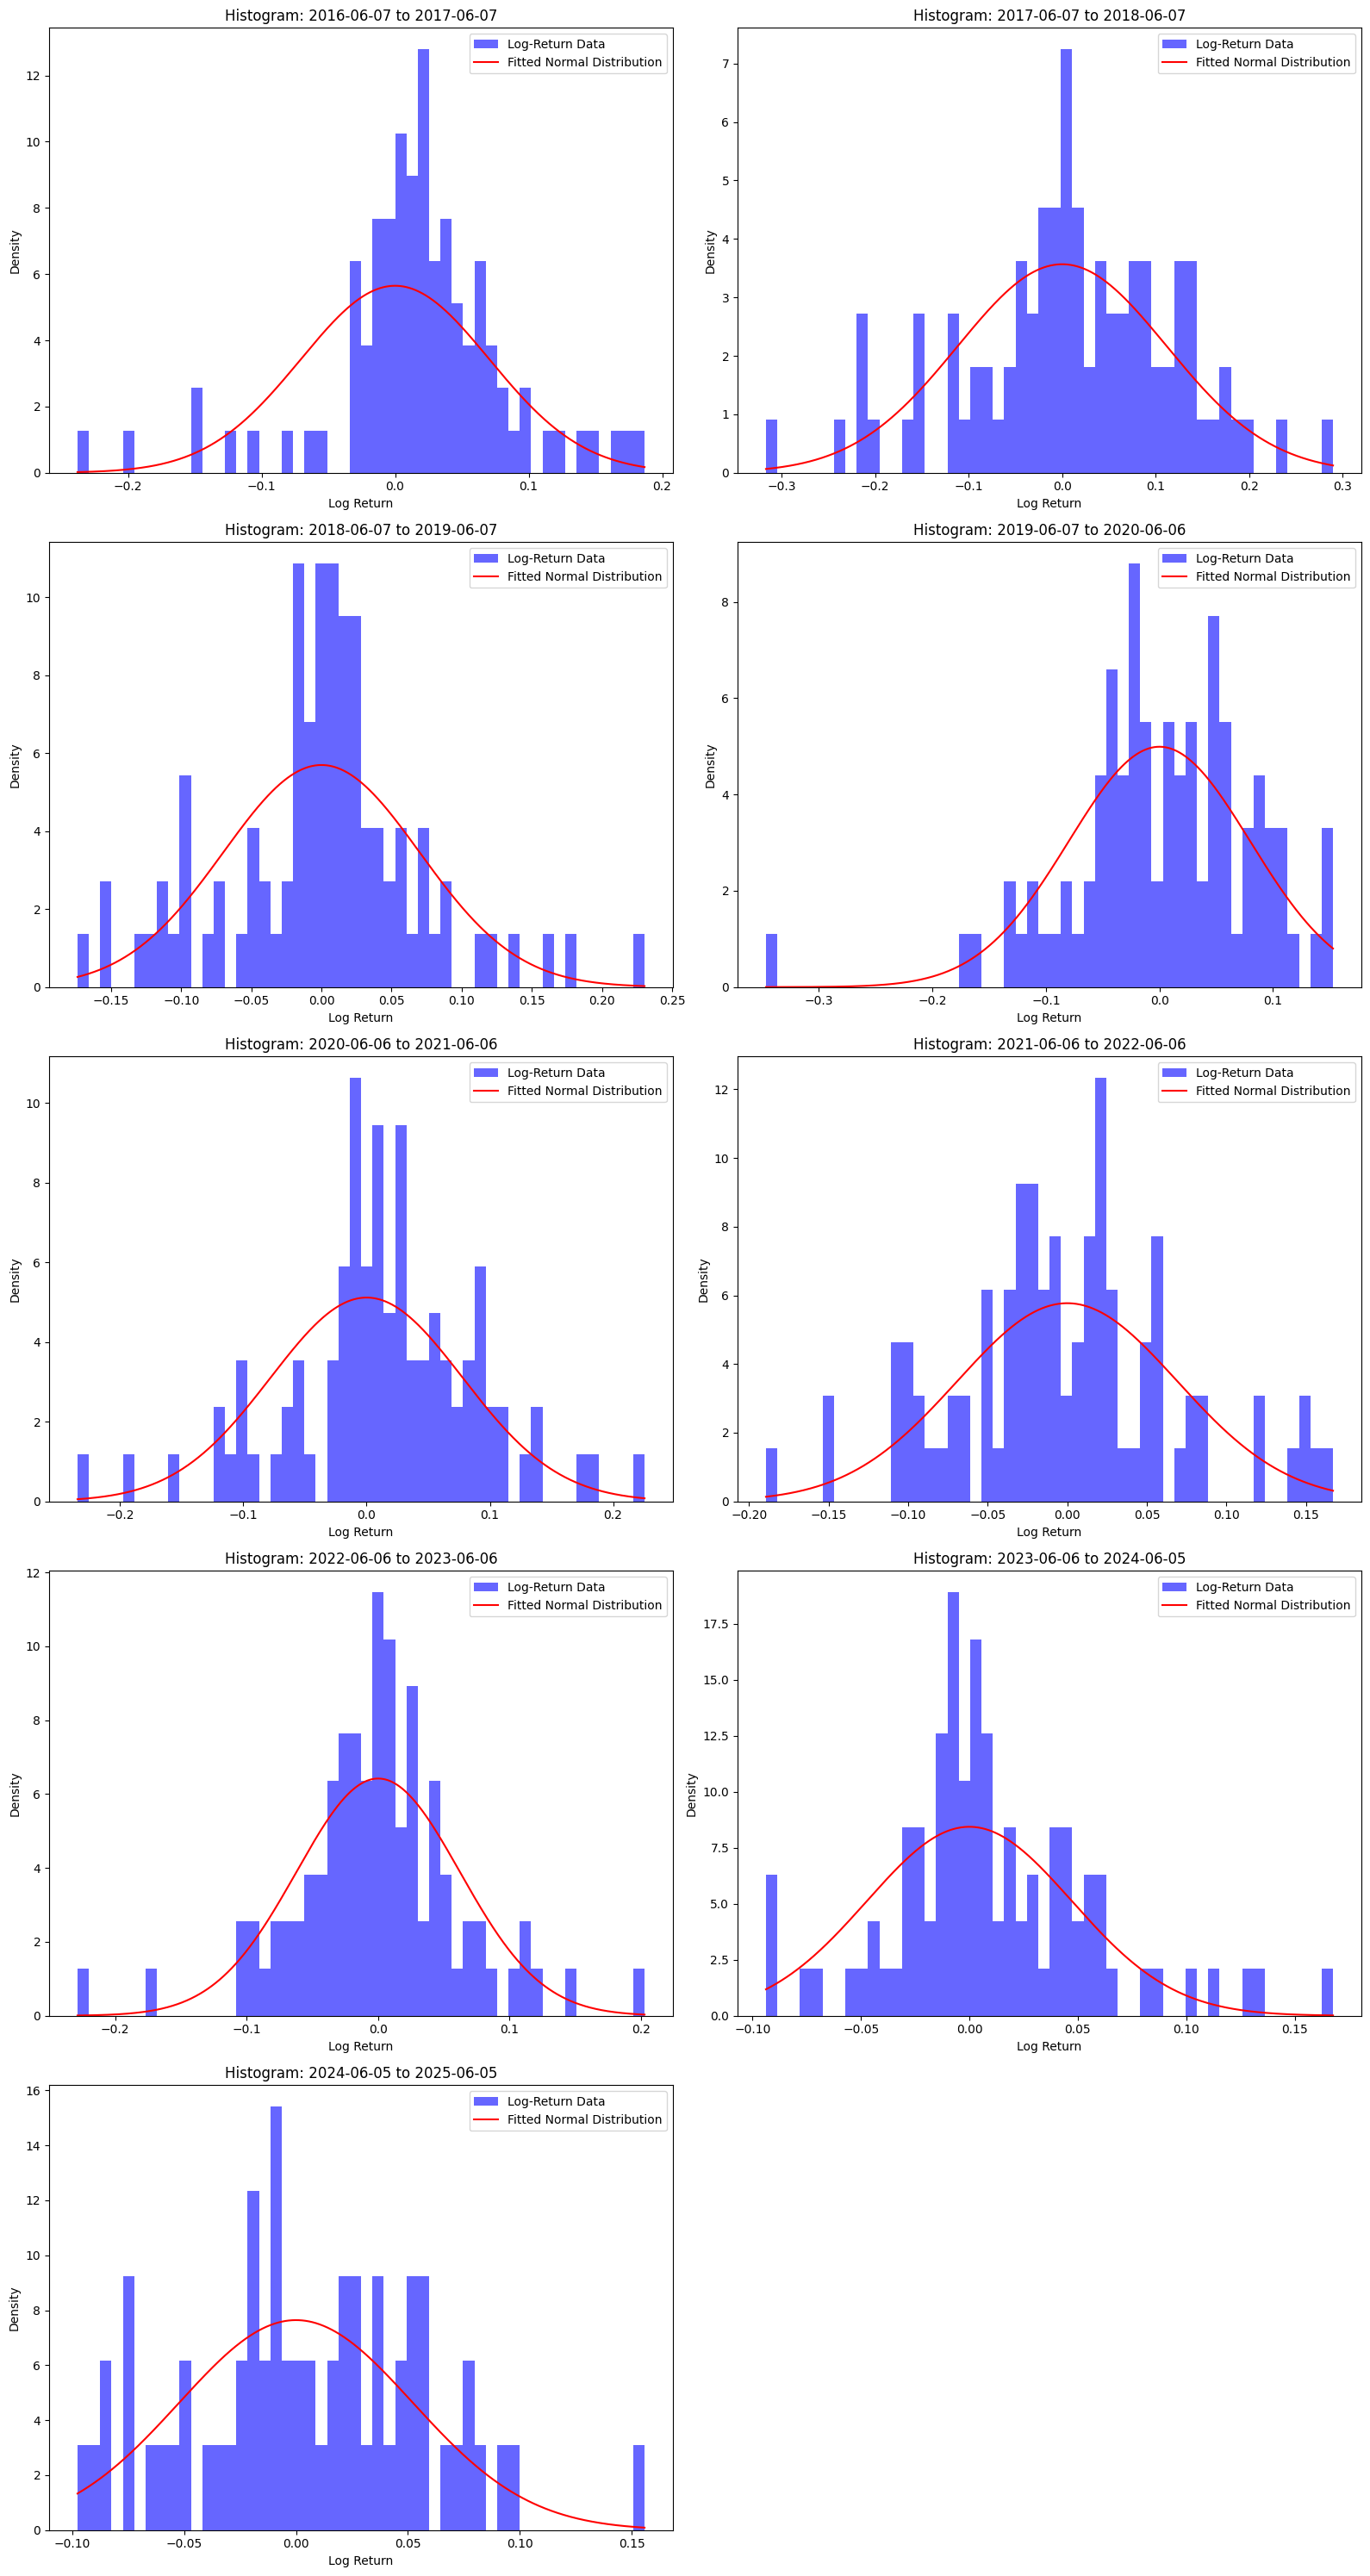

In [11]:
# Split data into 365-day intervals
sliced_data = {}
start_date = df_filtered.index.min()
end_date = df_filtered.index.max()
current_start = start_date

# Loop to split data into subsets of 365 days
while current_start <= end_date:
    current_end = current_start + pd.Timedelta(days=365)
    label = f"{current_start.date()} to {current_end.date()}"
    sliced_data[label] = df_filtered[(df_filtered.index >= current_start) & (df_filtered.index < current_end)]['log-return'].dropna()
    current_start = current_end

# Create subplots for histograms
num_subplots = len(sliced_data)
num_rows = (num_subplots + 1) // 2  # Calculate dynamic rows for 2 columns grid
fig, axes = plt.subplots(num_rows, 2, figsize=(16, 6 * num_rows))  # Dynamic figure size
axes = axes.flatten()  # Flatten for easy indexing

# Plot each subset in the grid
for ax, (label, data) in zip(axes, sliced_data.items()):
    if data is None or len(data) == 0:
        ax.axis('off')  # Hide empty subplot
        continue

    # Normal fit for each subset
    mu, sigma = norm.fit(data, floc=0)
    x = np.linspace(min(data), max(data), 1000)
    pdf = norm.pdf(x, mu, sigma)

    # Plot the histogram and fitted PDF
    count, bins, _ = ax.hist(data, bins=50, density=True, alpha=0.6, color='blue', label="Log-Return Data")
    ax.plot(x, pdf, 'r-', label='Fitted Normal Distribution')

    # Add titles, labels, and legend
    ax.set_title(f'Histogram: {label}')
    ax.set_xlabel('Log Return')
    ax.set_ylabel('Density')
    ax.legend()

# Loop to compare consecutive distributions using keys at indices
keys = list(sliced_data.keys())
for i in range(0, len(sliced_data) - 1):
    key1 = keys[i]   # Get key at index i
    key2 = keys[i + 1]  # Get key at index i + 1
    data1 = np.sort(sliced_data[key1])
    data2 = np.sort(sliced_data[key2])

    # Perform Kolmogorow-Smirnov test
    stat, p = kstest(data1, data2)

    print(f"Kolmogorov-Smirnov test for distribution comparison ({key1} to {key2}):")
    print(f"Statistic: {stat}, \np-value: {p}")
    if p < 0.05:
        print("Reject null hypothesis: There is a significant difference between the distributions.")
    else:
        print("Fail to reject null hypothesis: Insufficient evidence to conclude a difference.")
    print()

# Hide unused subplots
for ax in axes[len(sliced_data):]:
    ax.axis('off')

# Adjust layout and show the grid
plt.tight_layout()
plt.show()

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import kstest, lognorm, norm
import numpy as np

# Load the CSV file into a DataFrame
df = pd.read_csv('data/btc_coinbase_prices.csv')

# Convert Date column to datetime
df['Time'] = pd.to_datetime(df['Time'])

# Set the 'Date' column as the index for better plotting control
df.set_index('Time', inplace=True)

# Add column 'log-return' as natural log of market-price to its value on the prior day using shift
df['log-return'] = np.log(df['Close'] / df['Close'].shift(1))

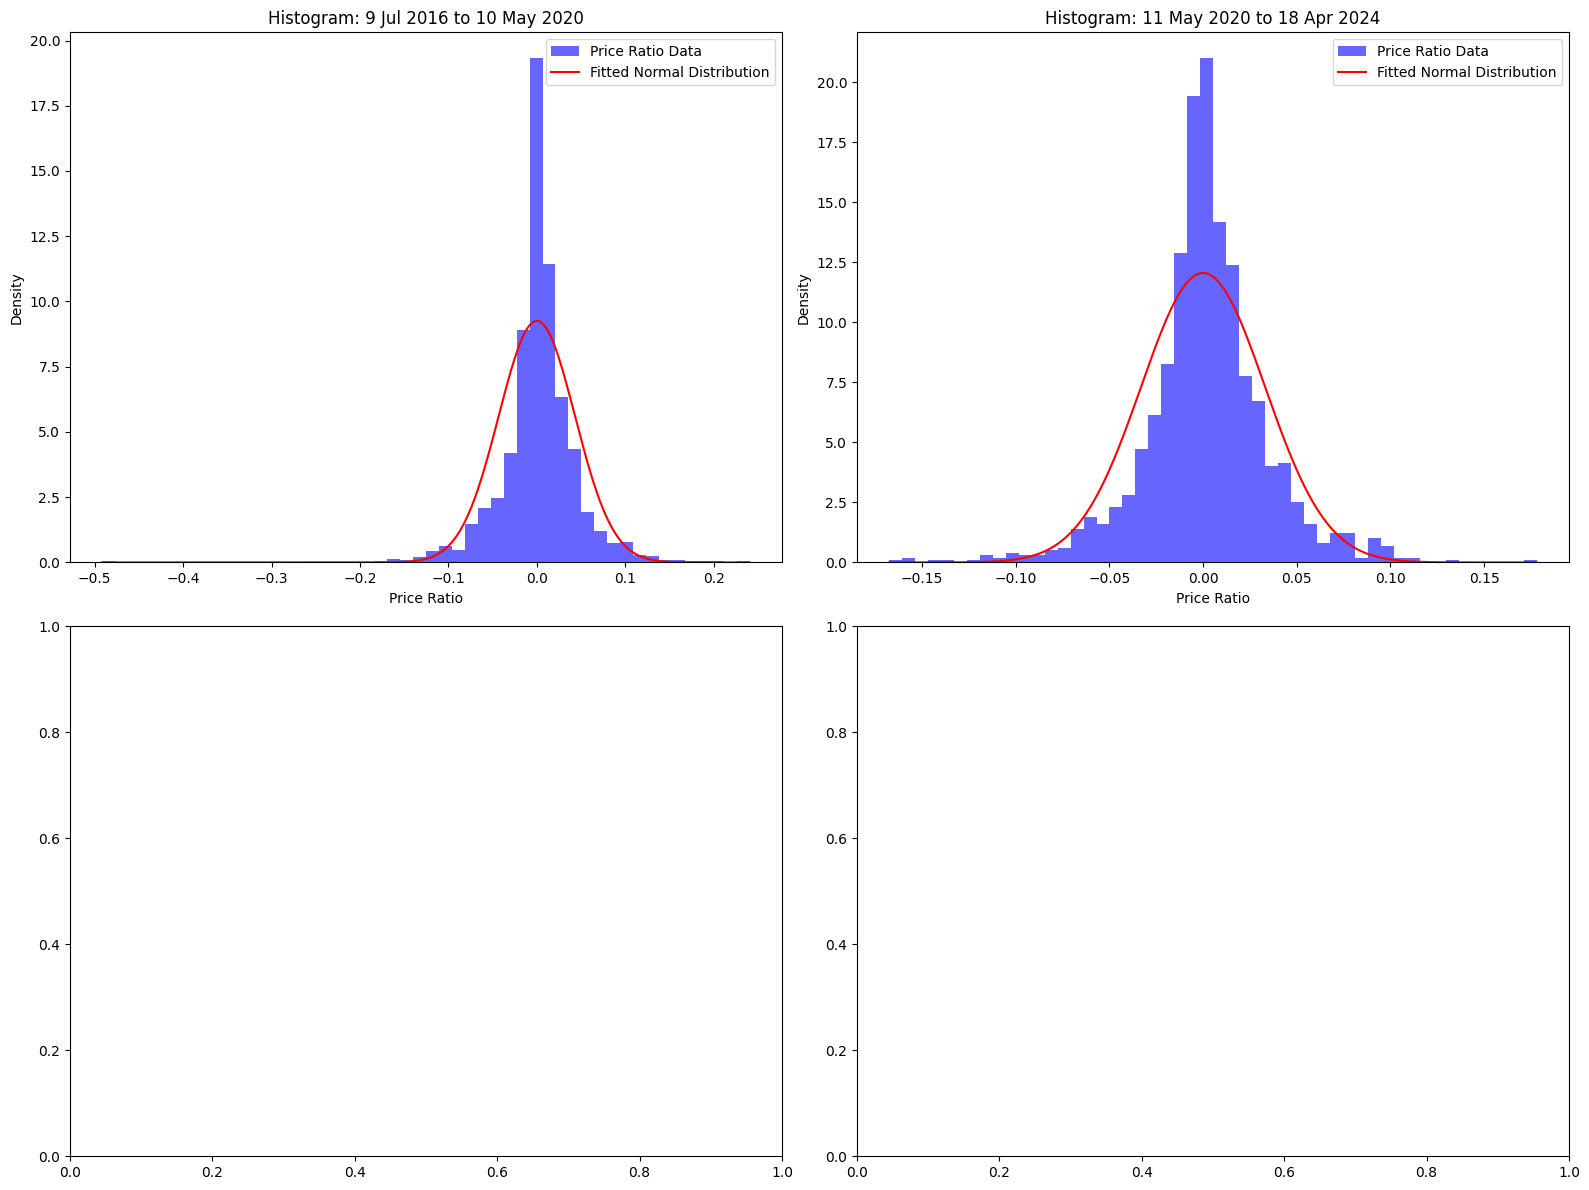

In [17]:
# Define the date ranges
date_ranges = {
    #'Start to 27 Nov 2012': ('1900-01-01', '2012-11-27'),
    #'28 Nov 2012 to 8 Jul 2016': ('2012-11-28', '2016-07-08'),
    '9 Jul 2016 to 10 May 2020': ('2016-07-09', '2020-05-10'),
    '11 May 2020 to 18 Apr 2024': ('2020-05-11', '2024-04-18')
}

# Slice the data into four datasets
sliced_data_daily = {label: df[(df.index >= start) & (df.index <= end)]['log-return'].dropna()
               for label, (start, end) in date_ranges.items()}

# Create subplots for histograms
fig, axes = plt.subplots(2, 2, figsize=(16, 12))  # 2x2 grid of subplots
axes = axes.flatten()  # Flatten for easy indexing

for ax, (label, data) in zip(axes, sliced_data.items()):
    if data is None or len(data) == 0:
        print(f"Warning: Data subset '{label}' is empty. Skipping...")
        continue

    # Normal fit for each subset
    mu, sigma = norm.fit(data, floc=0)
    x = np.linspace(min(data), max(data), 1000)
    pdf = norm.pdf(x, mu, sigma)

    # Plot the histogram and fitted PDF
    count, bins, _ = ax.hist(data, bins=50, density=True, alpha=0.6, color='blue', label="Price Ratio Data")
    ax.plot(x, pdf, 'r-', label='Fitted Normal Distribution')

    # Add titles, labels, and legend
    ax.set_title(f'Histogram: {label}')
    ax.set_xlabel('Price Ratio')
    ax.set_ylabel('Density')
    ax.legend()

# Adjust layout and show the grid
plt.tight_layout()
plt.show()

Wilcoxon Rank Sum Test Results for distribution means:
Test Statistic: 0.922467068808727
p-value: 0.356284999936463
Fail to reject null hypothesis: Insufficient evidence to conclude a difference.

Kolmogorov-Smirnov test for distribution comparison:
Statistic: 0.040702798246127096, 
p-value: 0.18292436116869665
Fail to reject null hypothesis: Insufficient evidence to conclude a difference.


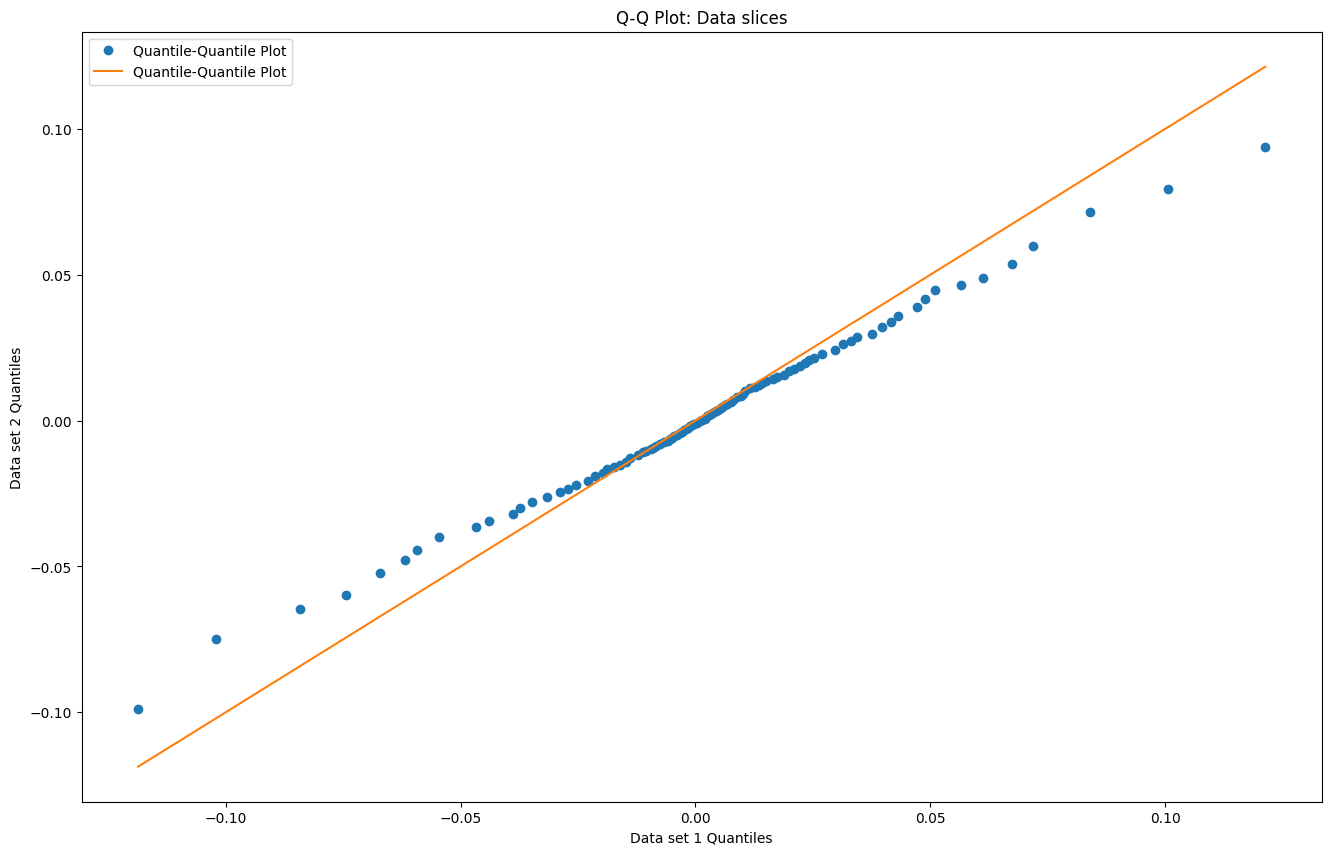

In [18]:
# Sample data (replace with your actual data)
data1 = np.sort(sliced_data_daily.get('9 Jul 2016 to 10 May 2020'))
data2 = np.sort(sliced_data_daily.get('11 May 2020 to 18 Apr 2024'))

# Perform Wilcoxon Rank Sum Test
statistic, pvalue = stats.ranksums(data1, data2)

# Print test results
print("Wilcoxon Rank Sum Test Results for distribution means:")
print("Test Statistic:", statistic)
print("p-value:", pvalue)

# Decide on rejecting the null hypothesis based on significance level (e.g., 0.05)
if pvalue < 0.05:
    print("Reject null hypothesis: There is a significant difference between the distributions.")
else:
    print("Fail to reject null hypothesis: Insufficient evidence to conclude a difference.")

print()

# Perform Kolmogorow-Smirnov test
stat, p = kstest(data1, data2)

print("Kolmogorov-Smirnov test for distribution comparison:")
print(f"Statistic: {stat}, \np-value: {p}")
if p < 0.05:
    print("Reject null hypothesis: There is a significant difference between the distributions.")
else:
    print("Fail to reject null hypothesis: Insufficient evidence to conclude a difference.")

# Calculate the quantiles for the lognormal distribution and empirical data
quantiles_x_vals = np.quantile(data1, np.arange(0.01, 1, 0.01))
quantiles_y_vals = np.quantile(data2, np.arange(0.01, 1, 0.01))

# Create a figure for the quantile-quantile plot
plt.figure(figsize=(16, 10))
plt.plot(quantiles_x_vals, quantiles_y_vals, marker='o', linestyle='', label='Quantile-Quantile Plot')

# Plot y=x
plt.plot(quantiles_x_vals, quantiles_x_vals, linestyle='-', label='Quantile-Quantile Plot')

# Add labels, title, and legend
plt.xlabel('Data set 1 Quantiles')
plt.ylabel('Data set 2 Quantiles')
plt.title('Q-Q Plot: Data slices')
plt.legend()

# Display the plot
plt.show()


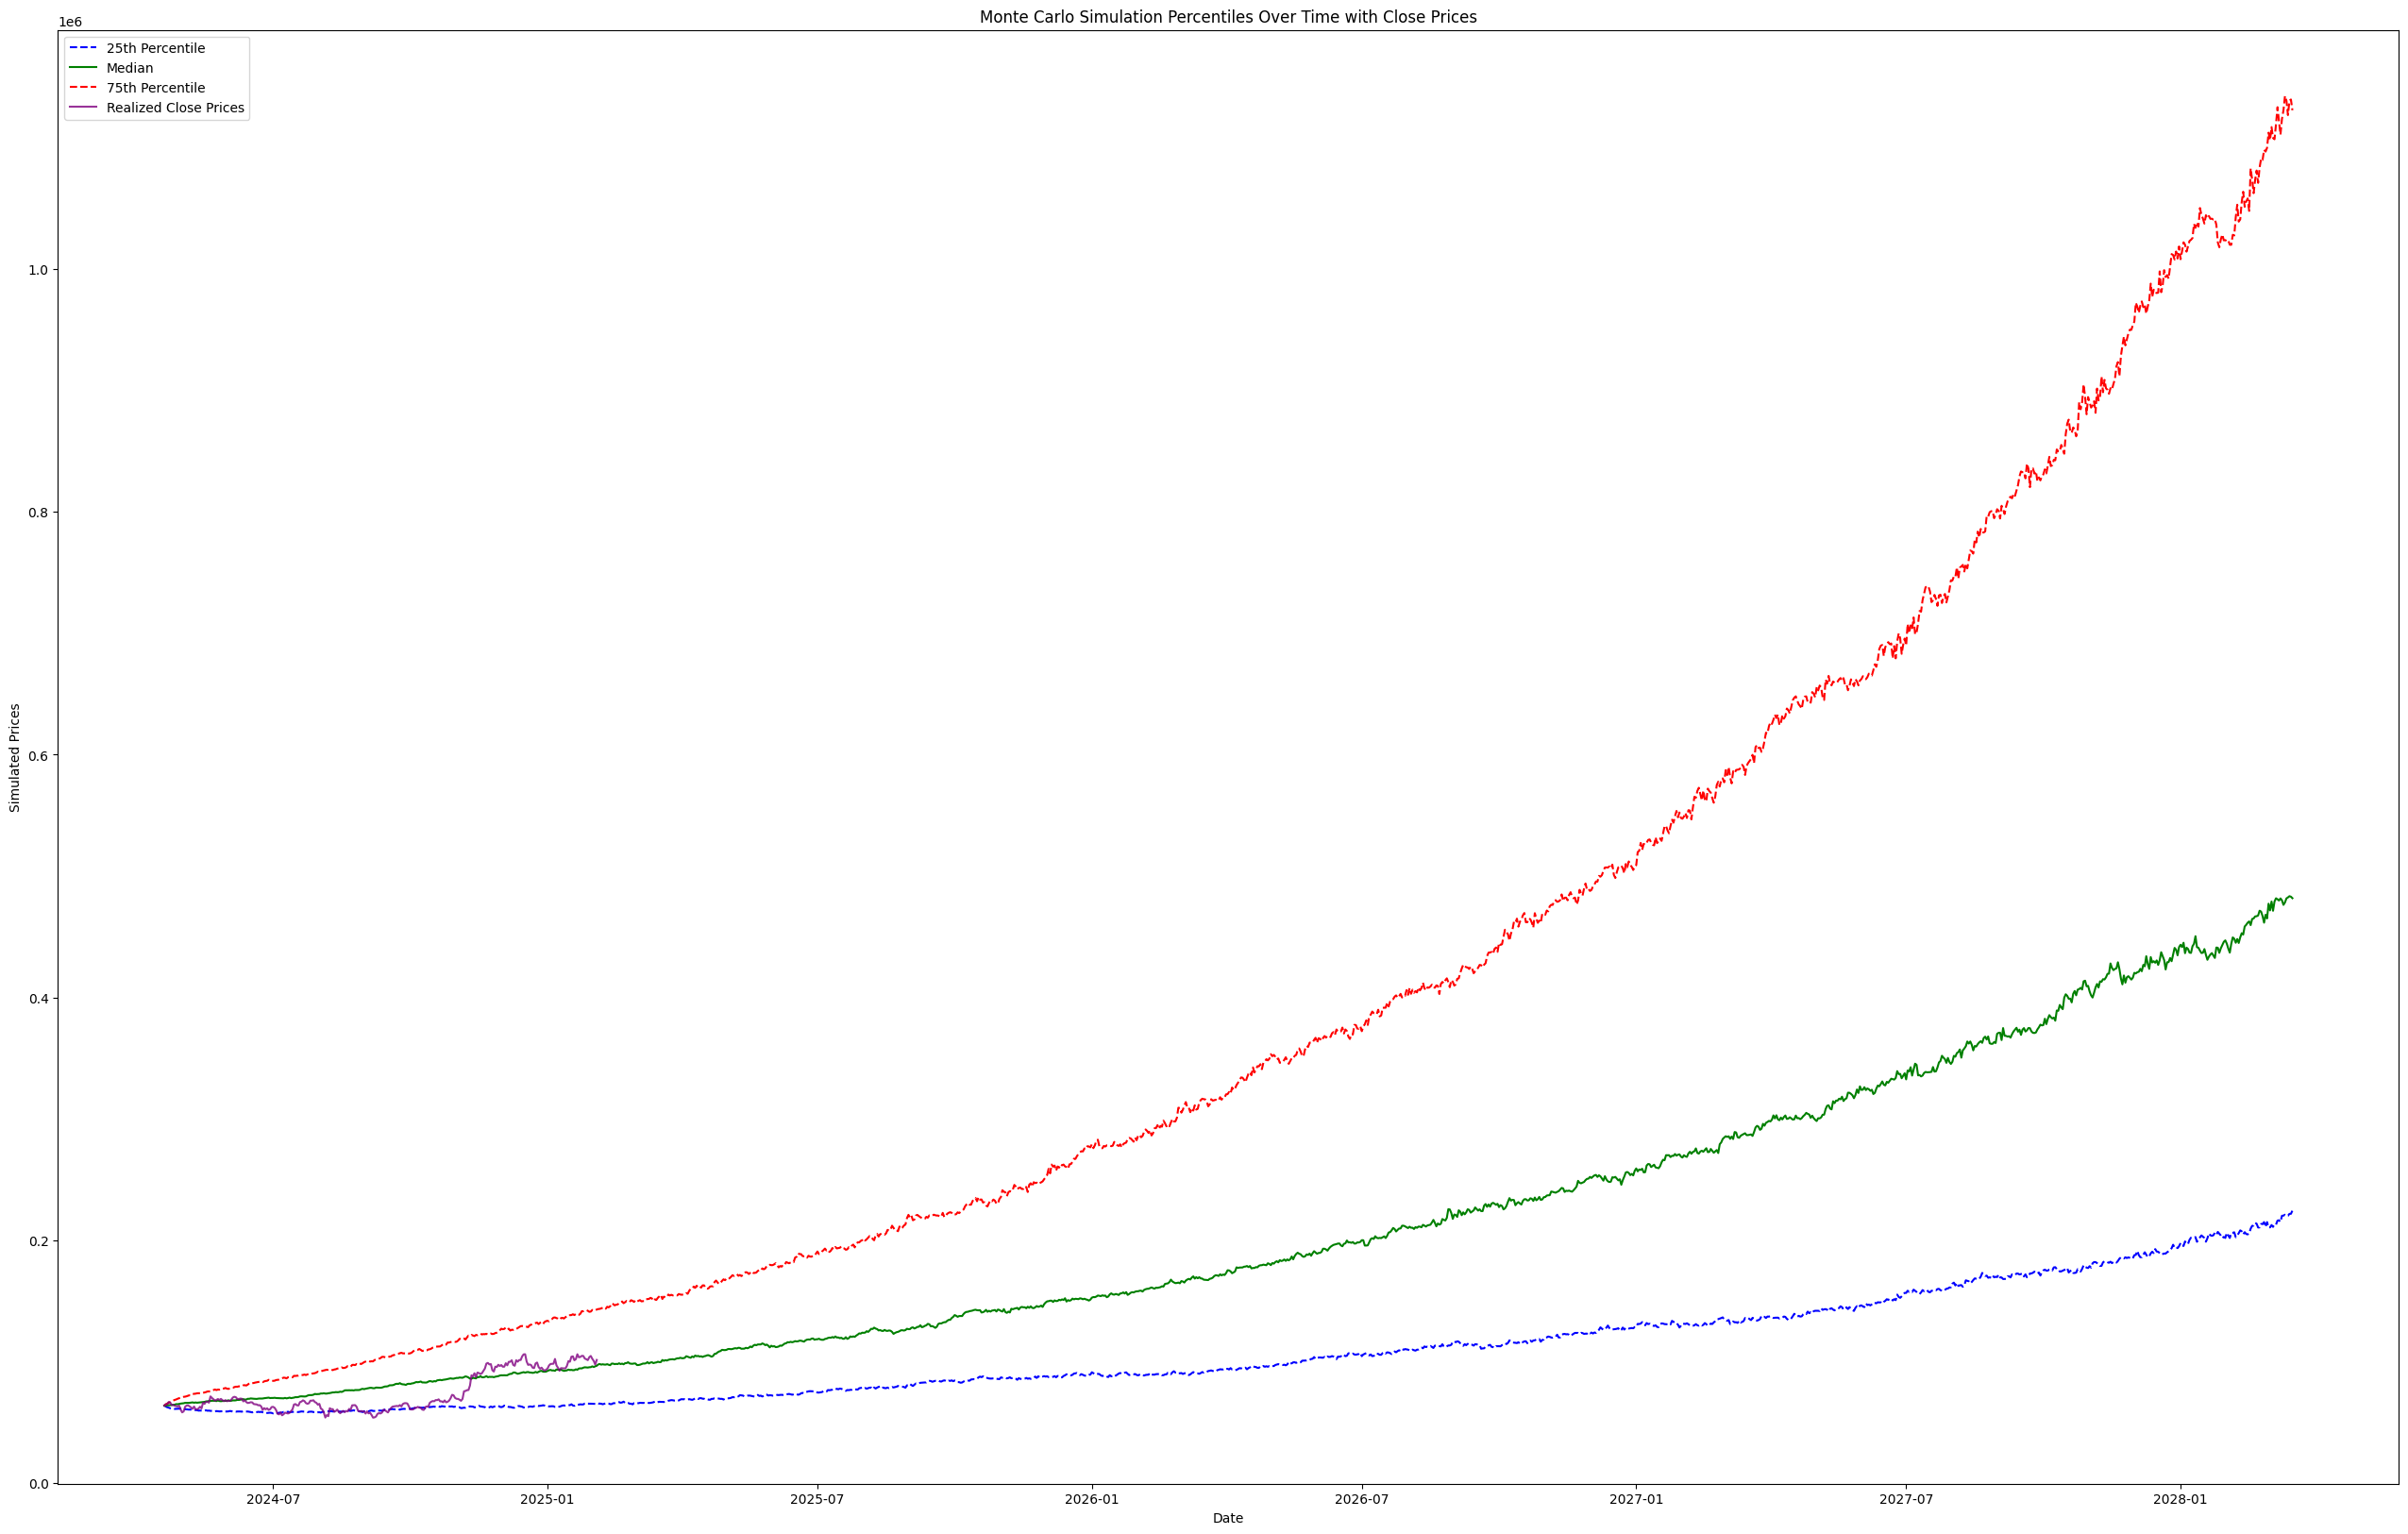

In [39]:
# Conduct a Monte Carlo simulation with 100 paths
num_paths = 1000
sampling_days = (pd.Timestamp('2028-03-16') - pd.Timestamp('2024-04-19')).days
random_samples = np.random.choice(data2, size=(sampling_days, num_paths), replace=True)

s0 = df.loc[pd.Timestamp('2024-04-19'), 'Close']

# Initialize a dictionary to store results
simulation_results = {}

# Calculate paths for all simulations
for i in range(num_paths):
    values = [s0]
    for r in random_samples[:, i]:
        values.append(values[-1] * np.exp(r))
    simulation_results[f'Path_{i+1}'] = values

# Convert the simulation results to a DataFrame
dates = pd.date_range(start='2024-04-19', periods=sampling_days + 1)
df_simulation_results = pd.DataFrame(simulation_results, index=dates)

# Calculate percentiles (5th, median, 95th) for each date
percentiles = {
    '25th Percentile': df_simulation_results.quantile(0.25, axis=1),
    'Median': df_simulation_results.median(axis=1),
    '75th Percentile': df_simulation_results.quantile(0.75, axis=1),
}

df_percentiles = pd.DataFrame(percentiles)

# Plot the percentiles over time
plt.figure(figsize=(32, 20))
plt.plot(df_percentiles.index, df_percentiles['25th Percentile'], label='25th Percentile', color='blue', linestyle='--')
plt.plot(df_percentiles.index, df_percentiles['Median'], label='Median', color='green', linestyle='-')
plt.plot(df_percentiles.index, df_percentiles['75th Percentile'], label='75th Percentile', color='red', linestyle='--')

# Plot df['Close'] for all available dates after start date
df_realized = df[df.index >= pd.Timestamp('2024-04-19')]
plt.plot(df_realized.index, df_realized['Close'], label='Realized Close Prices', color='purple', linestyle='-', alpha=0.8)

# Add labels, title, and legend
plt.title("Monte Carlo Simulation Percentiles Over Time with Close Prices")
plt.xlabel("Date")
plt.ylabel("Simulated Prices")
plt.legend()
plt.show()